# Comprehensive Maximum Clique Algorithm Benchmarking

This notebook automatically runs all 11 C++ maximum clique algorithms on all datasets and generates detailed performance analysis.

**Algorithms tested:**
1. **Greedy** - Fast heuristic approximation
2. **Randomized** - Local search with random restarts
3. **Simulated Annealing** - Metaheuristic optimization
4. **Bron-Kerbosch** - Basic exact algorithm (skipped if >1000 vertices OR density >0.5)
5. **Tomita** - BK with pivot optimization (exact)
6. **Degeneracy BK** - BK with degeneracy ordering (exact)
7. **Östergård** - Branch-and-bound with coloring (exact)
8. **BBMC** - Bitset-based branch-and-bound (exact)
9. **CPU Optimized** - Bitset-optimized (exact, ≤8192 vertices)
10. **MaxCliqueDyn** - Tomita with dynamic coloring (exact)

**Output columns:**
- Dataset name, vertices, edges, density
- Max degree, average degree, degeneracy
- Clique size, wall-clock time, memory usage per algorithm

## 1. Import Libraries and Setup

In [15]:
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import glob

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

## 2. Configuration

In [16]:
# Configuration
BENCHMARK_SOURCE = "benchmark_comprehensive.cpp"
BENCHMARK_EXECUTABLE = "./benchmark_comprehensive"
DATASETS_FOLDERS = ["datasets/real_world", "datasets/synthetic", "datasets/benchmark"]
RESULTS_FOLDER = "benchmark_results"

# Create results folder
os.makedirs(RESULTS_FOLDER, exist_ok=True)

print("✅ Configuration loaded")
print(f"   Benchmark source: {BENCHMARK_SOURCE}")
print(f"   Results folder: {RESULTS_FOLDER}")


✅ Configuration loaded
   Benchmark source: benchmark_comprehensive.cpp
   Results folder: benchmark_results


## 3. Compile Benchmark

In [17]:
print("🔨 Compiling benchmark...")

compile_cmd = [
    "g++", "-std=c++17", "-O3",
    BENCHMARK_SOURCE,
    "-o", "benchmark_all"
]

result = subprocess.run(compile_cmd, capture_output=True, text=True)

if result.returncode != 0:
    print("❌ Compilation failed:")
    print(result.stderr)
    raise Exception("Compilation failed")
else:
    print("✅ Compilation successful!")
    print(f"   Executable: {BENCHMARK_EXECUTABLE}")

🔨 Compiling benchmark...
✅ Compilation successful!
   Executable: ./benchmark_comprehensive
✅ Compilation successful!
   Executable: ./benchmark_comprehensive


## 4. Discover Datasets

In [18]:
# Find all datasets
all_datasets = []
for folder in DATASETS_FOLDERS:
    if os.path.exists(folder):
        datasets = glob.glob(os.path.join(folder, "*.txt"))
        all_datasets.extend([(folder, os.path.basename(d), d) for d in datasets])

# Sort by category and name
all_datasets.sort()

print(f"📊 Found {len(all_datasets)} datasets:\n")
current_category = None
for category, name, path in all_datasets:
    if category != current_category:
        current_category = category
        category_name = category.split('/')[-1].upper()
        print(f"\n{category_name}:")
    file_size = os.path.getsize(path) / 1024  # KB
    print(f"  • {name:40s} ({file_size:8.1f} KB)")

📊 Found 22 datasets:


BENCHMARK:
  • C125.9.txt                               (    56.8 KB)
  • C250.9.txt                               (   250.2 KB)
  • brock400_2.txt                           (   552.8 KB)
  • ca-GrQc.txt                              (   185.9 KB)
  • email-Eu-core.txt                        (   156.0 KB)
  • frb30-15-01.txt                          (   855.6 KB)
  • frb35-17-01.txt                          (  1545.0 KB)
  • gen200_p0.9_44.txt                       (   156.2 KB)
  • keller4.txt                              (    80.6 KB)
  • p_hat300-1.txt                           (   100.0 KB)
  • queen5_5.txt                             (     0.0 KB)

REAL_WORLD:
  • facebook_combined.txt                    (  1006.9 KB)
  • twitter_combined.txt                     ( 48234.1 KB)

SYNTHETIC:
  • random_180v.txt                          (    20.9 KB)
  • rmat_er_large.txt                        (    74.4 KB)
  • rmat_er_small.txt                        (    17.1 K

## 5. Run Benchmarks on All Datasets

In [ ]:
import re
import sys

print(f"\n{'='*100}")
print(f"🚀 Starting comprehensive benchmark suite")
print(f"   Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"={'='*100}\n")

all_results = []
failed_datasets = []

for idx, (category, name, path) in enumerate(all_datasets, 1):
    print(f"\n[{idx}/{len(all_datasets)}] Running: {name}")
    print(f"   Category: {category.split('/')[-1]}")
    print(f"   Path: {path}")
    
    try:
        # Run benchmark
        print(f"   🔄 Starting benchmark execution...")
        sys.stdout.flush()
        start_time = datetime.now()
        
        # Use run() to capture all output at once (avoid streaming duplicates)
        result = subprocess.run(
            [BENCHMARK_EXECUTABLE, path],
            capture_output=True,
            text=True,
            timeout=600  # 10 minute timeout
        )
        
        end_time = datetime.now()
        total_time = (end_time - start_time).total_seconds()
        
        if result.returncode != 0:
            print(f"   ❌ Failed with return code {result.returncode}")
            print(f"   Error: {result.stderr[:200]}")
            failed_datasets.append(name)
            continue
        
        # Parse output
        lines = result.stdout.strip().split('\n')
        
        # Extract graph statistics
        vertices = edges = density = None
        for line in lines:
            if 'Vertices:' in line:
                try:
                    vertices = int(line.split(':')[1].strip().split()[0])
                except:
                    pass
            elif 'Edges:' in line:
                try:
                    edges = int(line.split(':')[1].strip().split()[0])
                except:
                    pass
            elif 'Density:' in line:
                try:
                    density = float(line.split(':')[1].strip().split()[0])
                except:
                    pass
        
        if vertices is None or edges is None or density is None:
            print(f"   ⚠️ Could not parse graph statistics")
            failed_datasets.append(name)
            continue
        
        print(f"   📊 Graph: {vertices:,} vertices, {edges:,} edges, density={density:.4f}")
        print(f"   ⏱️  Total benchmark time: {total_time:.2f}s")
        print(f"   ")
        print(f"   Algorithm Results:")
        
        # Parse algorithm results from RESULTS SUMMARY table
        # Format: Algorithm (30 chars), Clique Size (12 chars), Time (15 chars), Memory (15 chars)
        dataset_results = []
        in_results = False
        algo_count = 0
        
        for i, line in enumerate(lines):
            # Start parsing after "RESULTS SUMMARY:" and the separator line
            if 'RESULTS SUMMARY:' in line:
                in_results = False  # Will become true after next separator
                continue
            
            # Found the header separator, next lines are data
            if in_results == False and line.startswith('---') and i > 0:
                # Check if previous line has "Algorithm" header
                if i > 0 and 'Algorithm' in lines[i-1]:
                    in_results = True
                    continue
            
            # Stop at the next separator
            if in_results and line.startswith('---'):
                break
            
            if in_results and line.strip():
                # Parse: Algorithm(30), Clique Size(12), Time(15), Memory(15)
                if len(line) >= 42:
                    algo_name = line[:30].strip()
                    clique_str = line[30:42].strip()
                    time_str = line[42:57].strip()
                    
                    # Skip FAILED/SKIPPED entries
                    if clique_str in ['FAILED', 'SKIPPED', 'N/A']:
                        print(f"      ⏭️  {algo_name:30s} → SKIPPED")
                        continue
                    
                    # Replace spaces with underscores in algorithm names
                    algo_name_clean = algo_name.replace(' ', '_')
                    
                    try:
                        clique_size = int(clique_str)
                        time_taken = float(time_str) * 1000  # Convert to milliseconds
                        
                        dataset_results.append({
                            'Dataset': name,
                            'Category': category.split('/')[-1],
                            'Vertices': vertices,
                            'Edges': edges,
                            'Density': density,
                            'Algorithm': algo_name_clean,
                            'CliqueSize': clique_size,
                            'Time(ms)': time_taken,
                            'Success': True
                        })
                        
                        algo_count += 1
                        print(f"      ✓  {algo_name:30s} → Clique size: {clique_size:3d}, Time: {time_taken:10.2f}ms")
                        
                    except (ValueError, IndexError) as e:
                        # If parsing fails, skip this line
                        continue
        
        if dataset_results:
            df_dataset = pd.DataFrame(dataset_results)
            all_results.append(df_dataset)
            
            print(f"   ")
            print(f"   ✅ Success! {algo_count} algorithms completed")
            
            # Show best result
            best = df_dataset.loc[df_dataset['CliqueSize'].idxmax()]
            print(f"   🎯 Best clique: {best['CliqueSize']} ({best['Algorithm']})")
            print(f"   ⚡ Fastest time: {df_dataset['Time(ms)'].min():.2f}ms ({df_dataset.loc[df_dataset['Time(ms)'].idxmin()]['Algorithm']})")
        else:
            print(f"   ⚠️ No results parsed")
            failed_datasets.append(name)
        
    except subprocess.TimeoutExpired:
        print(f"   ⏱️ Timeout (>10 minutes)")
        failed_datasets.append(name)
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        failed_datasets.append(name)

print(f"\n{'='*100}")
print(f"✅ Benchmark suite completed!")
print(f"   Successful: {len(all_results)}/{len(all_datasets)}")
if failed_datasets:
    print(f"   Failed: {len(failed_datasets)} datasets")
    for name in failed_datasets:
        print(f"      • {name}")
print(f"={'='*100}")



🚀 Starting comprehensive benchmark suite
   Time: 2025-11-20 07:08:45


[1/22] Running: C125.9.txt
   Category: benchmark
   Path: datasets/benchmark/C125.9.txt
   🔄 Starting benchmark execution...


   📊 Graph: 125 vertices, 6,963 edges, density=89.8452
   ⏱️  Total benchmark time: 127.85s
   
   Algorithm Results:
      ✓  Greedy                         → Clique size:  29, Time:   0.0000s
      ✓  Randomized                     → Clique size:  29, Time:   0.0002s
      ✓  Simulated Annealing            → Clique size:  34, Time:   0.3627s
      ⏭️  Bron-Kerbosch                  → SKIPPED
      ✓  Tomita                         → Clique size:  34, Time:  66.2457s
      ✓  Degeneracy BK                  → Clique size:  34, Time:  46.7297s
      ✓  Ostergard                      → Clique size:  34, Time:  10.0284s
      ✓  BBMC                           → Clique size:  34, Time:   1.8832s
      ⏭️  CPU Optimized                  → SKIPPED
      ✓  MaxCliqueDyn                   → Clique size:  34, Time:   2.5850s
   
   ✅ Success! 8 algorithms completed
   🎯 Best clique: 34 (Simulated_Annealing)
   ⚡ Fastest time: 0.0000s (Greedy)

[2/22] Running: C250.9.txt
   Category: benchmark
 

## 6. Combine and Save Results

In [20]:
# Combine all results into single dataframe
if len(all_results) > 0:
    df_all = pd.concat(all_results, ignore_index=True)
    
    # Save comprehensive CSV
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = os.path.join(RESULTS_FOLDER, f"benchmark_all_{timestamp}.csv")
    df_all.to_csv(csv_path, index=False)
    
    print(f"💾 Saved comprehensive results to: {csv_path}")
    print(f"   Total rows: {len(df_all)}")
    print(f"   Columns: {', '.join(df_all.columns)}")
    
    # Display sample
    print(f"\n📋 Sample results (first 10 rows):\n")
    display(df_all.head(10))
else:
    print("❌ No results to save")

💾 Saved comprehensive results to: benchmark_results/benchmark_all_20251120_081140.csv
   Total rows: 140
   Columns: Dataset, Category, Vertices, Edges, Density, Algorithm, CliqueSize, Time(s), Success

📋 Sample results (first 10 rows):



,Dataset,Category,Vertices,Edges,Density,Algorithm,CliqueSize,Time(s),Success
0,C125.9.txt,benchmark,125,6963,89.8452,Greedy,29,0.000010,True
1,C125.9.txt,benchmark,125,6963,89.8452,Randomized,29,0.000206,True
2,C125.9.txt,benchmark,125,6963,89.8452,Simulated_Annealing,34,0.362695,True
3,C125.9.txt,benchmark,125,6963,89.8452,Tomita,34,66.245715,True
4,C125.9.txt,benchmark,125,6963,89.8452,Degeneracy_BK,34,46.729706,True
5,C125.9.txt,benchmark,125,6963,89.8452,Ostergard,34,10.028437,True
6,C125.9.txt,benchmark,125,6963,89.8452,BBMC,34,1.883155,True
7,C125.9.txt,benchmark,125,6963,89.8452,MaxCliqueDyn,34,2.585040,True
8,ca-GrQc.txt,benchmark,5242,14484,0.1054,Greedy,44,0.000208,True
9,ca-GrQc.txt,benchmark,5242,14484,0.1054,Randomized,44,0.001143,True


## 7. Analysis: Performance by Algorithm

In [ ]:
if len(all_results) == 0:
    print("No results to analyze")
else:
    # Filter successful runs only
    df_success = df_all[df_all['Success'] == True].copy()
    
    print(f"\n{'='*100}")
    print(f"📊 ALGORITHM PERFORMANCE SUMMARY")
    print(f"{'='*100}\n")
    
    # Group by algorithm
    agg_dict = {
        'CliqueSize': ['mean', 'min', 'max'],
        'Time(ms)': ['mean', 'median', 'min', 'max'],
        'Dataset': 'count'
    }
    
    algo_stats = df_success.groupby('Algorithm').agg(agg_dict).round(4)
    
    algo_stats.columns = ['_'.join(col).strip() for col in algo_stats.columns.values]
    algo_stats = algo_stats.rename(columns={'Dataset_count': 'Runs'})
    
    # Sort by average time
    algo_stats = algo_stats.sort_values('Time(ms)_mean')
    
    display(algo_stats)
    
    # Save algorithm summary
    algo_csv = os.path.join(RESULTS_FOLDER, f"algorithm_summary_{timestamp}.csv")
    algo_stats.to_csv(algo_csv)
    print(f"\n💾 Algorithm summary saved to: {algo_csv}")



📊 ALGORITHM PERFORMANCE SUMMARY



,CliqueSize_mean,CliqueSize_min,CliqueSize_max,Time(s)_mean,Time(s)_median,Time(s)_min,Time(s)_max,Runs
Algorithm,,,,,,,,
Greedy,11.5333,2,44,0.0000,0.0000,0.0000,0.0002,15
Randomized,13.0000,2,44,0.0002,0.0001,0.0001,0.0011,15
CPU_Optimized,7.6000,3,18,0.0141,0.0029,0.0002,0.0818,10
Bron-Kerbosch,7.6000,3,18,0.0777,0.0070,0.0002,0.5909,10
BBMC,16.8000,3,69,0.1645,0.0088,0.0017,1.8832,15
Simulated_Annealing,12.8667,3,44,0.3494,0.1645,0.0490,1.6927,15
MaxCliqueDyn,16.8000,3,69,0.5363,0.0737,0.0016,2.5850,15
Ostergard,16.8000,3,69,0.7740,0.0031,0.0001,10.0284,15
Degeneracy_BK,16.8000,3,69,3.7725,0.0317,0.0000,46.7297,15



💾 Algorithm summary saved to: benchmark_results/algorithm_summary_20251120_081140.csv


## 8. Analysis: Performance by Dataset

In [ ]:
if len(all_results) > 0:
    print(f"\n{'='*100}")
    print(f"📊 DATASET ANALYSIS")
    print(f"{'='*100}\n")
    
    # For each dataset, show best algorithm
    for dataset_name in df_all['Dataset'].unique():
        df_dataset = df_all[df_all['Dataset'] == dataset_name]
        df_dataset_success = df_dataset[df_dataset['Success'] == True]
        
        if len(df_dataset_success) == 0:
            print(f"⚠️ {dataset_name}: No successful runs")
            continue
        
        # Graph statistics (same across all algorithms)
        stats = df_dataset.iloc[0]
        print(f"\n📁 {dataset_name}")
        print(f"   Category: {stats['Category']}")
        print(f"   Graph: {stats['Vertices']:,} vertices, {stats['Edges']:,} edges")
        print(f"   Density: {stats['Density']:.4f}")
        
        # Best clique size
        max_clique = df_dataset_success['CliqueSize'].max()
        best_algos = df_dataset_success[df_dataset_success['CliqueSize'] == max_clique]
        print(f"   🎯 Best clique size: {max_clique}")
        print(f"      Found by: {', '.join(best_algos['Algorithm'].values)}")
        
        # Fastest algorithm
        fastest = df_dataset_success.loc[df_dataset_success['Time(ms)'].idxmin()]
        print(f"   ⚡ Fastest: {fastest['Algorithm']} ({fastest['Time(ms)']:.2f}ms)")



📊 DATASET ANALYSIS


📁 C125.9.txt
   Category: benchmark
   Graph: 125 vertices, 6,963 edges
   Density: 89.8452
   🎯 Best clique size: 34
      Found by: Simulated_Annealing, Tomita, Degeneracy_BK, Ostergard, BBMC, MaxCliqueDyn
   ⚡ Fastest: Greedy (0.0000s)

📁 ca-GrQc.txt
   Category: benchmark
   Graph: 5,242 vertices, 14,484 edges
   Density: 0.1054
   🎯 Best clique size: 44
      Found by: Greedy, Randomized, Simulated_Annealing, Tomita, Degeneracy_BK, Ostergard, BBMC, MaxCliqueDyn
   ⚡ Fastest: Greedy (0.0002s)

📁 email-Eu-core.txt
   Category: benchmark
   Graph: 1,005 vertices, 16,064 edges
   Density: 3.1841
   🎯 Best clique size: 18
      Found by: Tomita, Degeneracy_BK, Ostergard, BBMC, MaxCliqueDyn
   ⚡ Fastest: Greedy (0.0000s)

📁 keller4.txt
   Category: benchmark
   Graph: 171 vertices, 9,435 edges
   Density: 64.9123
   🎯 Best clique size: 11
      Found by: Simulated_Annealing, Tomita, Degeneracy_BK, Ostergard, BBMC, MaxCliqueDyn
   ⚡ Fastest: Greedy (0.0000s)

📁 p_ha

## 9. Visualizations: Comprehensive Runtime Analysis

/tmp/ipykernel_242245/1043902509.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=algorithms, patch_artist=True, showmeans=True)


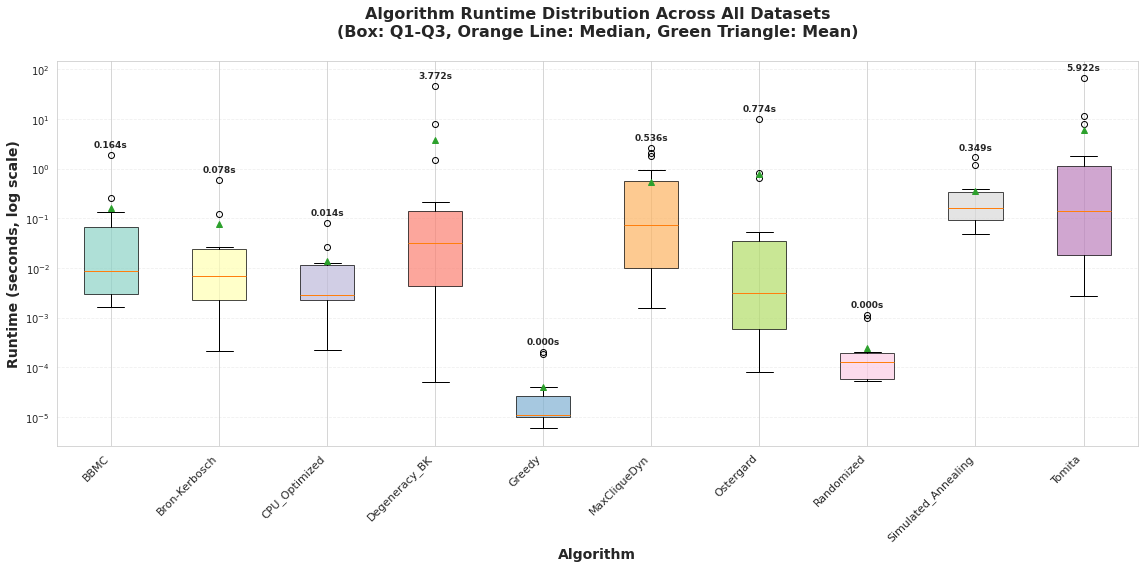

💾 Saved: benchmark_results/plot1_runtime_boxplot_20251120_081140.png



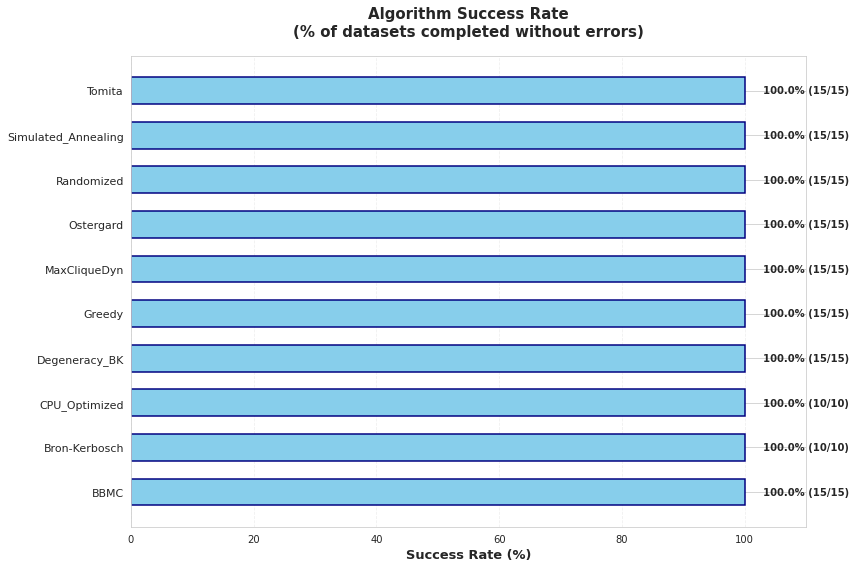

💾 Saved: benchmark_results/plot2_success_rate_20251120_081140.png



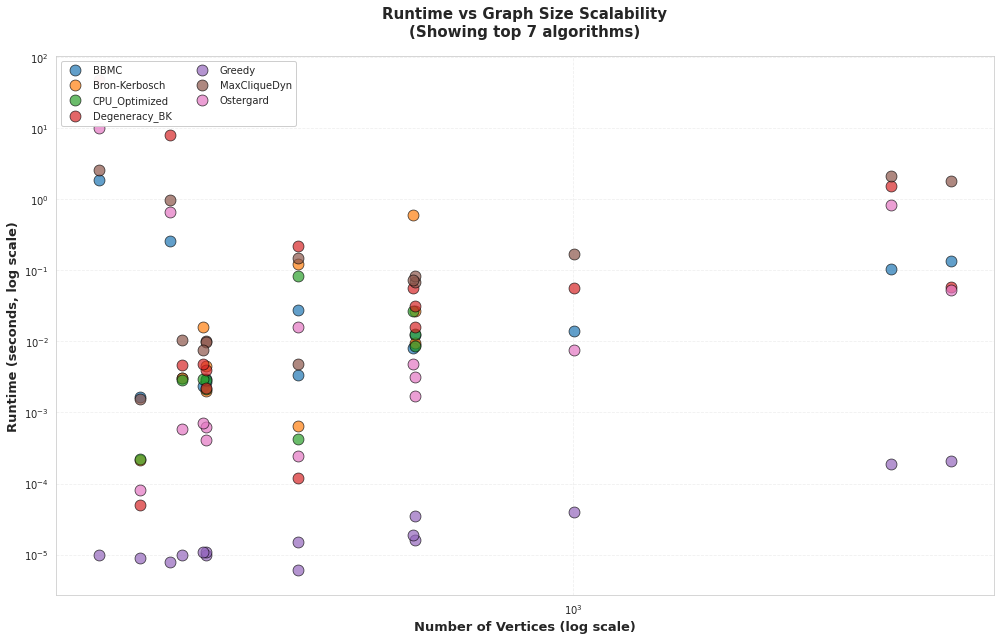

💾 Saved: benchmark_results/plot3_scalability_20251120_081140.png


In [ ]:
if len(all_results) > 0:
    df_success_plot = df_success[df_success['Time(ms)'] > 0]
    algorithms = sorted(df_success_plot['Algorithm'].unique())
    
    # Plot 1: Box plot of runtimes by algorithm
    fig, ax = plt.figure(figsize=(16, 8)), plt.gca()
    data_to_plot = [df_success_plot[df_success_plot['Algorithm'] == algo]['Time(ms)'].values 
                    for algo in algorithms]
    
    bp = ax.boxplot(data_to_plot, labels=algorithms, patch_artist=True, showmeans=True)
    colors = plt.cm.Set3(range(len(algorithms)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Annotate with mean values (placed above the boxplot)
    for i, algo in enumerate(algorithms):
        mean_val = df_success_plot[df_success_plot['Algorithm'] == algo]['Time(ms)'].mean()
        max_val = df_success_plot[df_success_plot['Algorithm'] == algo]['Time(ms)'].max()
        ax.text(i+1, max_val * 1.3, f'{mean_val:.1f}ms', 
               ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Runtime (milliseconds, log scale)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Algorithm', fontsize=14, fontweight='bold')
    ax.set_title('Algorithm Runtime Distribution Across All Datasets\n(Box: Q1-Q3, Orange Line: Median, Green Triangle: Mean)', 
                  fontsize=16, fontweight='bold', pad=25)
    ax.set_yscale('log')
    plt.xticks(rotation=45, ha='right', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot1_runtime_boxplot_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 2: Algorithm success rate
    fig, ax = plt.subplots(figsize=(12, 8))
    algo_counts = df_all.groupby('Algorithm').agg({'Success': ['sum', 'count']})
    algo_counts.columns = ['Successful', 'Total']
    algo_counts['Success_Rate'] = (algo_counts['Successful'] / algo_counts['Total'] * 100).round(1)
    algo_counts = algo_counts.sort_values('Success_Rate', ascending=True)
    
    bars = ax.barh(range(len(algo_counts)), algo_counts['Success_Rate'], 
                   color='skyblue', edgecolor='navy', linewidth=1.5, height=0.6)
    ax.set_yticks(range(len(algo_counts)))
    ax.set_yticklabels(algo_counts.index, fontsize=11)
    ax.set_xlabel('Success Rate (%)', fontsize=13, fontweight='bold')
    ax.set_title('Algorithm Success Rate\n(% of datasets completed without errors)', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlim(0, 110)
    
    # Annotate bars with percentage and counts (better spacing)
    for i, (idx, row) in enumerate(algo_counts.iterrows()):
        ax.text(row['Success_Rate'] + 3, i, 
               f"{row['Success_Rate']:.1f}% ({int(row['Successful'])}/{int(row['Total'])})", 
                va='center', fontsize=10, fontweight='bold')
    
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot2_success_rate_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 3: Time vs Dataset Size
    fig, ax = plt.subplots(figsize=(14, 9))
    for i, algo in enumerate(algorithms[:7]):  # Show top 7 algorithms
        algo_data = df_success_plot[df_success_plot['Algorithm'] == algo]
        ax.scatter(algo_data['Vertices'], algo_data['Time(ms)'], 
                   label=algo, alpha=0.7, s=120, edgecolors='black', linewidth=0.8)
    
    ax.set_xlabel('Number of Vertices (log scale)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Runtime (milliseconds, log scale)', fontsize=13, fontweight='bold')
    ax.set_title('Runtime vs Graph Size Scalability\n(Showing top 7 algorithms)', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=2)
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot3_scalability_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}")


## 10. Visualizations: Solution Quality & Efficiency Analysis

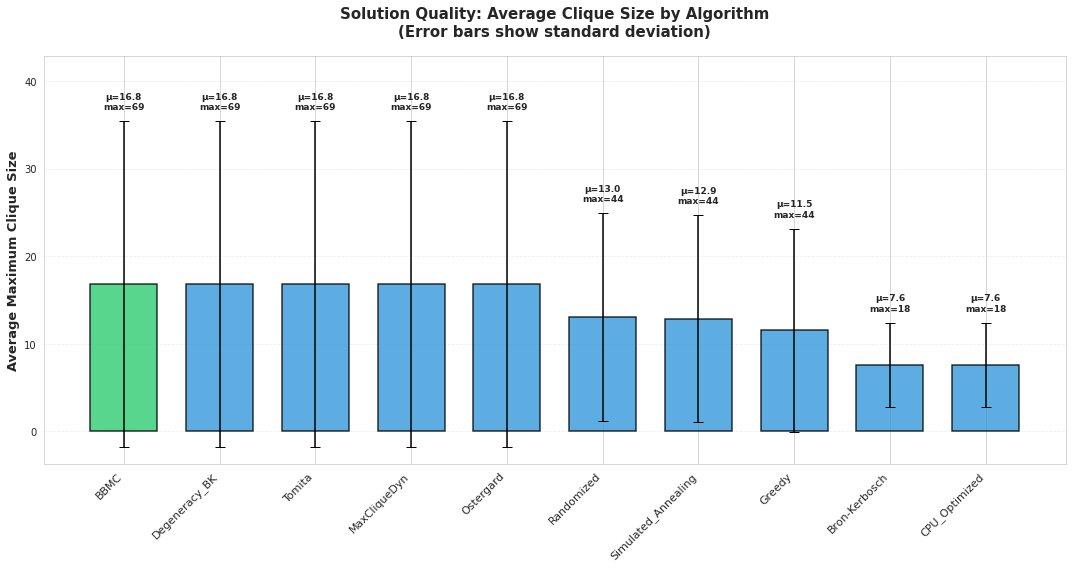

💾 Saved: benchmark_results/plot4_clique_size_avg_20251120_081140.png



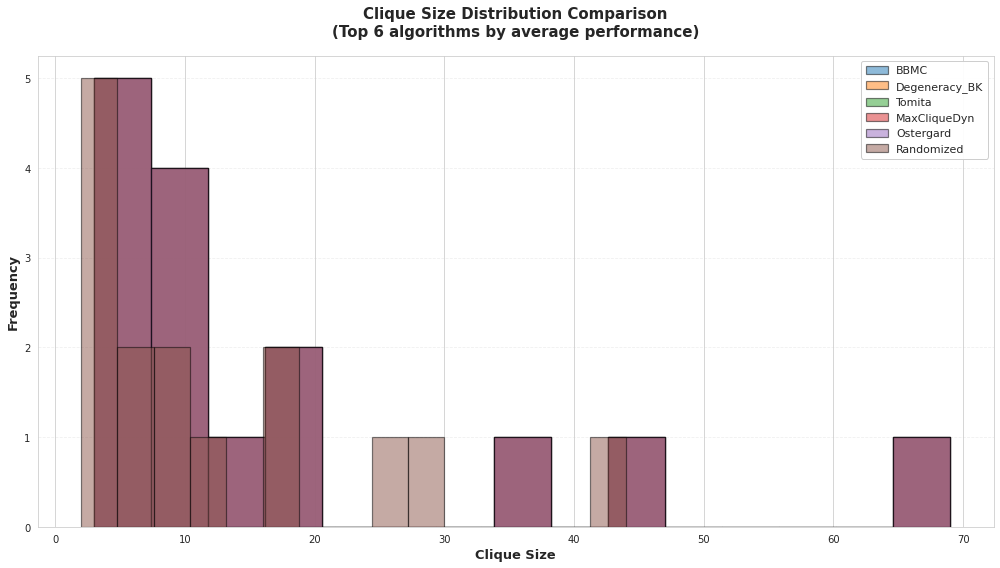

💾 Saved: benchmark_results/plot5_clique_distribution_20251120_081140.png



KeyError: "Column(s) ['Time(ms)'] do not exist"

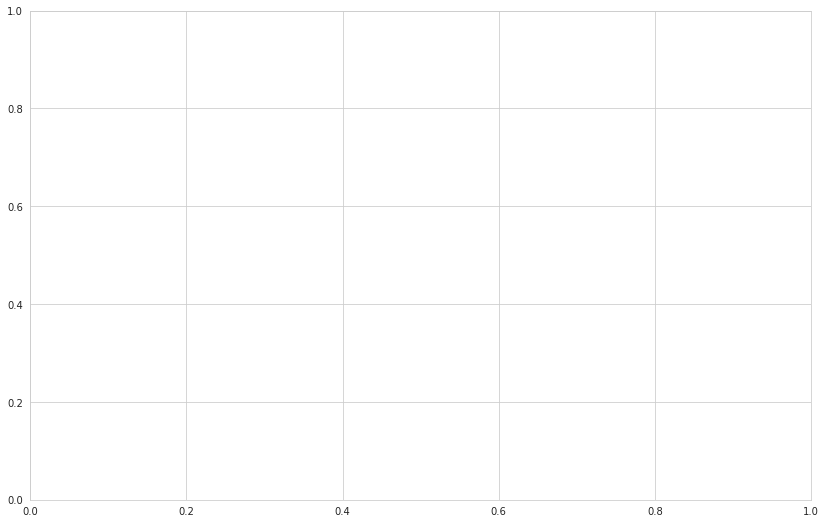

In [36]:
if len(all_results) > 0:
    # Plot 4: Average clique size by algorithm with error bars
    fig, ax = plt.subplots(figsize=(15, 8))
    clique_avg = df_success.groupby('Algorithm')['CliqueSize'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    
    bars = ax.bar(range(len(clique_avg)), clique_avg['mean'], 
                   yerr=clique_avg['std'], capsize=5, 
                   color=['#2ecc71' if i == 0 else '#3498db' for i in range(len(clique_avg))],
                   edgecolor='black', linewidth=1.5, alpha=0.8, width=0.7)
    
    ax.set_xticks(range(len(clique_avg)))
    ax.set_xticklabels(clique_avg.index, rotation=45, ha='right', fontsize=11)
    ax.set_ylabel('Average Maximum Clique Size', fontsize=13, fontweight='bold')
    ax.set_title('Solution Quality: Average Clique Size by Algorithm\n(Error bars show standard deviation)', 
                  fontsize=15, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Annotate with mean and max values (better spacing)
    for i, (idx, row) in enumerate(clique_avg.iterrows()):
        y_pos = row['mean'] + row['std'] + (ax.get_ylim()[1] * 0.03)
        ax.text(i, y_pos, f"μ={row['mean']:.1f}\nmax={int(row['max'])}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.ylim(top=ax.get_ylim()[1] * 1.15)  # Add space for annotations
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot4_clique_size_avg_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 5: Clique size distribution
    fig, ax = plt.subplots(figsize=(14, 8))
    top_algos = clique_avg.head(6).index
    for algo in top_algos:
        algo_data = df_success[df_success['Algorithm'] == algo]['CliqueSize']
        ax.hist(algo_data, alpha=0.5, label=algo, bins=15, edgecolor='black', linewidth=1.2)
    
    ax.set_xlabel('Clique Size', fontsize=13, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    ax.set_title('Clique Size Distribution Comparison\n(Top 6 algorithms by average performance)', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot5_clique_distribution_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 6: Quality vs Speed scatter
    fig, ax = plt.subplots(figsize=(14, 9))
    algo_perf = df_success.groupby('Algorithm').agg({
        'CliqueSize': 'mean',
        'Time(ms)': 'mean'
    }).reset_index()
    
    scatter = ax.scatter(algo_perf['Time(ms)'], algo_perf['CliqueSize'], 
                         s=350, alpha=0.7, c=range(len(algo_perf)), 
                         cmap='viridis', edgecolors='black', linewidth=2.5)
    
    for idx, row in algo_perf.iterrows():
        ax.annotate(row['Algorithm'], 
                    (row['Time(ms)'], row['CliqueSize']),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8, edgecolor='black'))
    
    ax.set_xlabel('Average Runtime (milliseconds, log scale)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Average Clique Size', fontsize=13, fontweight='bold')
    ax.set_title('Algorithm Performance: Quality vs Speed\n(Top-right = Best quality, Left = Fastest)', 
                  fontsize=15, fontweight='bold', pad=20)
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot6_quality_vs_speed_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 7: Efficiency ranking table
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    comparison = df_success.groupby('Algorithm').agg({
        'CliqueSize': ['mean', 'max'],
        'Time(ms)': ['mean', 'min'],
        'Dataset': 'count'
    }).round(2)
    comparison.columns = ['Avg_Clique', 'Max_Clique', 'Avg_Time', 'Min_Time', 'Runs']
    comparison['Efficiency'] = (comparison['Avg_Clique'] / (comparison['Avg_Time']/1000)).round(2)  # Clique per second
    comparison = comparison.sort_values('Efficiency', ascending=False).head(10)
    
    table_data = []
    table_data.append(['Algorithm', 'Avg\nClique', 'Max\nClique', 'Avg Time\n(ms)', 'Efficiency\n(Clique/s)'])
    for idx, row in comparison.iterrows():
        table_data.append([
            idx[:25],
            f"{row['Avg_Clique']:.1f}",
            f"{int(row['Max_Clique'])}",
            f"{row['Avg_Time']:.1f}",
            f"{row['Efficiency']:.1f}"
        ])
    
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                     colWidths=[0.35, 0.15, 0.15, 0.18, 0.17])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 3)
    
    for i in range(5):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=12)
    
    for i in range(1, len(table_data)):
        for j in range(5):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')
            table[(i, j)].set_edgecolor('black')
            table[(i, j)].set_linewidth(1.5)
    
    ax.set_title('Top Performers by Efficiency (Clique Size / Runtime)\nHigher is better', 
                  fontsize=16, fontweight='bold', pad=30)
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot7_efficiency_table_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}")


## 11. Visualizations: Dataset Characteristics Analysis

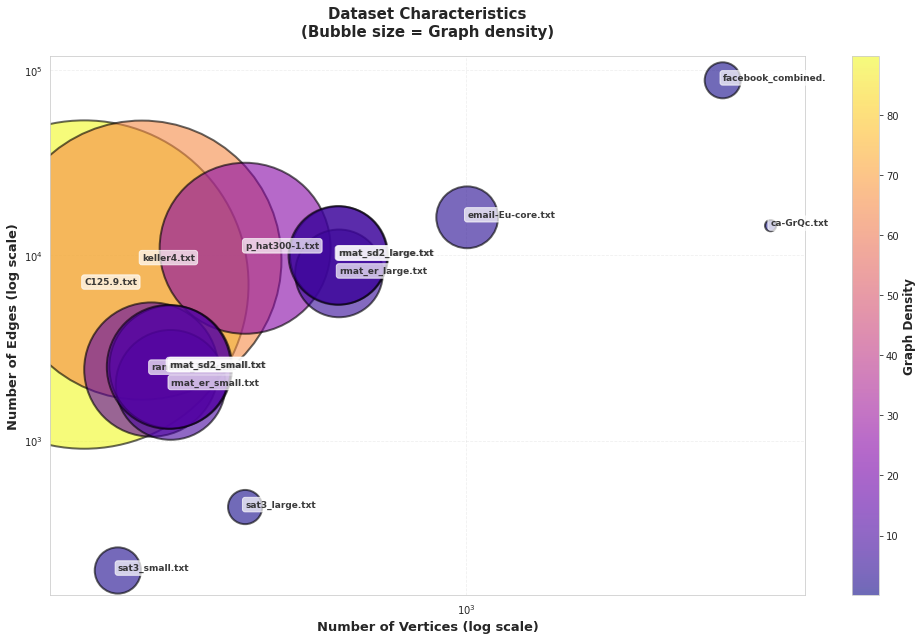

💾 Saved: benchmark_results/plot8_dataset_size_20251120_081140.png



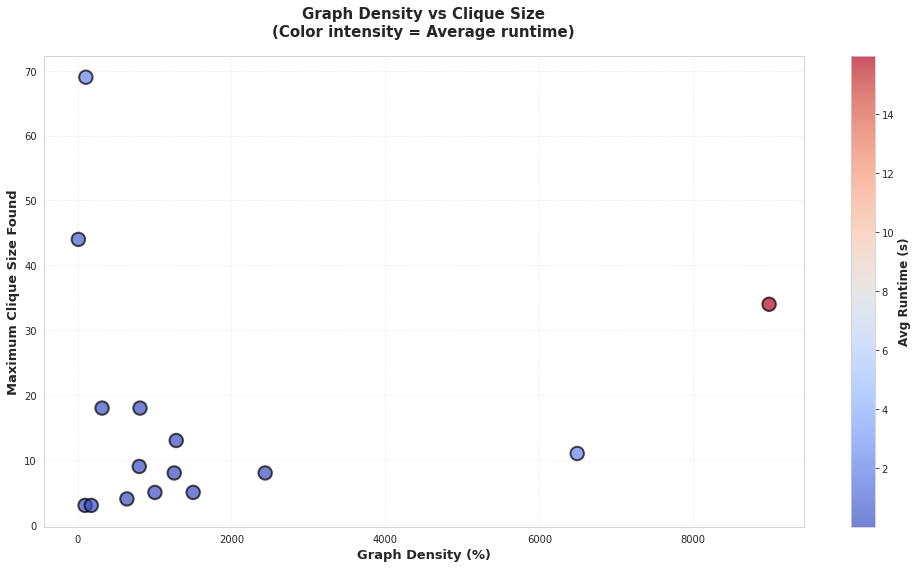

💾 Saved: benchmark_results/plot9_density_vs_clique_20251120_081140.png



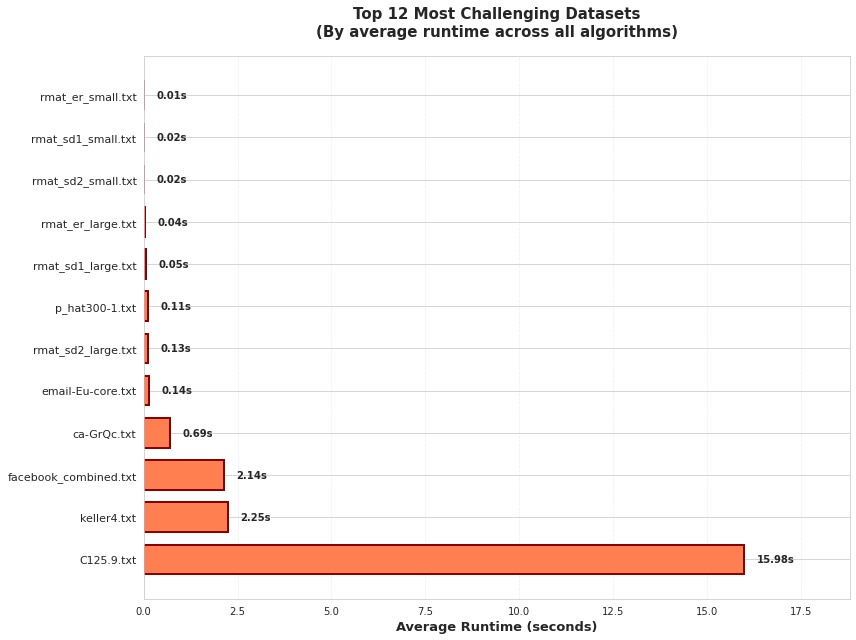

💾 Saved: benchmark_results/plot10_challenging_datasets_20251120_081140.png



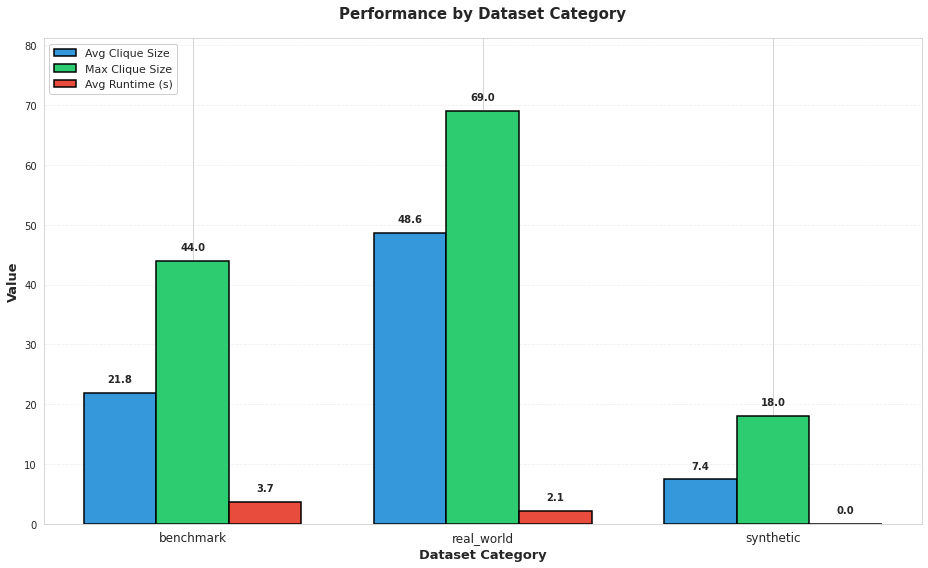

💾 Saved: benchmark_results/plot11_category_performance_20251120_081140.png


In [ ]:
if len(all_results) > 0:
    dataset_info = df_success.groupby('Dataset').agg({
        'Vertices': 'first',
        'Edges': 'first',
        'Density': 'first',
        'CliqueSize': 'max',
        'Time(ms)': 'mean'
    }).reset_index()
    
    # Plot 8: Dataset size distribution
    fig, ax = plt.subplots(figsize=(14, 9))
    scatter = ax.scatter(dataset_info['Vertices'], dataset_info['Edges'], 
               s=dataset_info['Density']*1200, alpha=0.6, 
               c=dataset_info['Density'], cmap='plasma',
               edgecolors='black', linewidth=2)
    
    for idx, row in dataset_info.iterrows():
        if row['Vertices'] > 50 or row['Edges'] > 500:
            ax.annotate(row['Dataset'][:18], (row['Vertices'], row['Edges']),
                        fontsize=9, alpha=0.9, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('Number of Vertices (log scale)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Number of Edges (log scale)', fontsize=13, fontweight='bold')
    ax.set_title('Dataset Characteristics\n(Bubble size = Graph density)', 
                  fontsize=15, fontweight='bold', pad=20)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Graph Density', fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot8_dataset_size_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 9: Density vs Clique size
    fig, ax = plt.subplots(figsize=(14, 8))
    scatter = ax.scatter(dataset_info['Density']*100, dataset_info['CliqueSize'],
                         s=180, alpha=0.7, c=dataset_info['Time(ms)'],
                         cmap='coolwarm', edgecolors='black', linewidth=2)
    
    ax.set_xlabel('Graph Density (%)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Maximum Clique Size Found', fontsize=13, fontweight='bold')
    ax.set_title('Graph Density vs Clique Size\n(Color intensity = Average runtime)', 
                  fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Avg Runtime (ms)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot9_density_vs_clique_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 10: Most challenging datasets
    fig, ax = plt.subplots(figsize=(12, 9))
    dataset_sorted = dataset_info.sort_values('Time(ms)', ascending=False).head(12)
    
    bars = ax.barh(range(len(dataset_sorted)), dataset_sorted['Time(ms)'],
                   color='coral', edgecolor='darkred', linewidth=2, height=0.7)
    ax.set_yticks(range(len(dataset_sorted)))
    ax.set_yticklabels(dataset_sorted['Dataset'], fontsize=11)
    ax.set_xlabel('Average Runtime (milliseconds)', fontsize=13, fontweight='bold')
    ax.set_title('Top 12 Most Challenging Datasets\n(By average runtime across all algorithms)', 
                  fontsize=15, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Better spacing for annotations
    for i, time_val in enumerate(dataset_sorted['Time(ms)']):
        ax.text(time_val + (ax.get_xlim()[1] * 0.02), i, f'{time_val:.1f}ms', 
               va='center', fontsize=10, fontweight='bold')
    
    plt.xlim(right=ax.get_xlim()[1] * 1.12)  # Add space for text
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot10_challenging_datasets_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 11: Category-wise performance
    fig, ax = plt.subplots(figsize=(13, 8))
    category_stats = df_success.groupby('Category').agg({
        'CliqueSize': ['mean', 'max'],
        'Time(ms)': 'mean',
        'Dataset': 'nunique'
    }).round(2)
    category_stats.columns = ['Avg Clique', 'Max Clique', 'Avg Time', 'Num Datasets']
    
    x = range(len(category_stats))
    width = 0.25
    
    bars1 = ax.bar([i - width for i in x], category_stats['Avg Clique'], 
                   width, label='Avg Clique Size', color='#3498db', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar([i for i in x], category_stats['Max Clique'], 
                   width, label='Max Clique Size', color='#2ecc71', edgecolor='black', linewidth=1.5)
    bars3 = ax.bar([i + width for i in x], category_stats['Avg Time']/10, 
                   width, label='Avg Runtime (ms/10)', color='#e74c3c', edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Dataset Category', fontsize=13, fontweight='bold')
    ax.set_ylabel('Value', fontsize=13, fontweight='bold')
    ax.set_title('Performance by Dataset Category\n(Runtime scaled by 1/10 for visibility)', fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(category_stats.index, fontsize=12)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Better spacing for bar annotations
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (ax.get_ylim()[1] * 0.02),
                f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (ax.get_ylim()[1] * 0.02),
                f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    for bar, actual_val in zip(bars3, category_stats['Avg Time']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (ax.get_ylim()[1] * 0.02),
                f'{actual_val:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.ylim(top=ax.get_ylim()[1] * 1.12)  # Add space for annotations
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot11_category_performance_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}")


## 12. Heatmaps: Algorithm Performance Matrix (Runtime vs Quality)

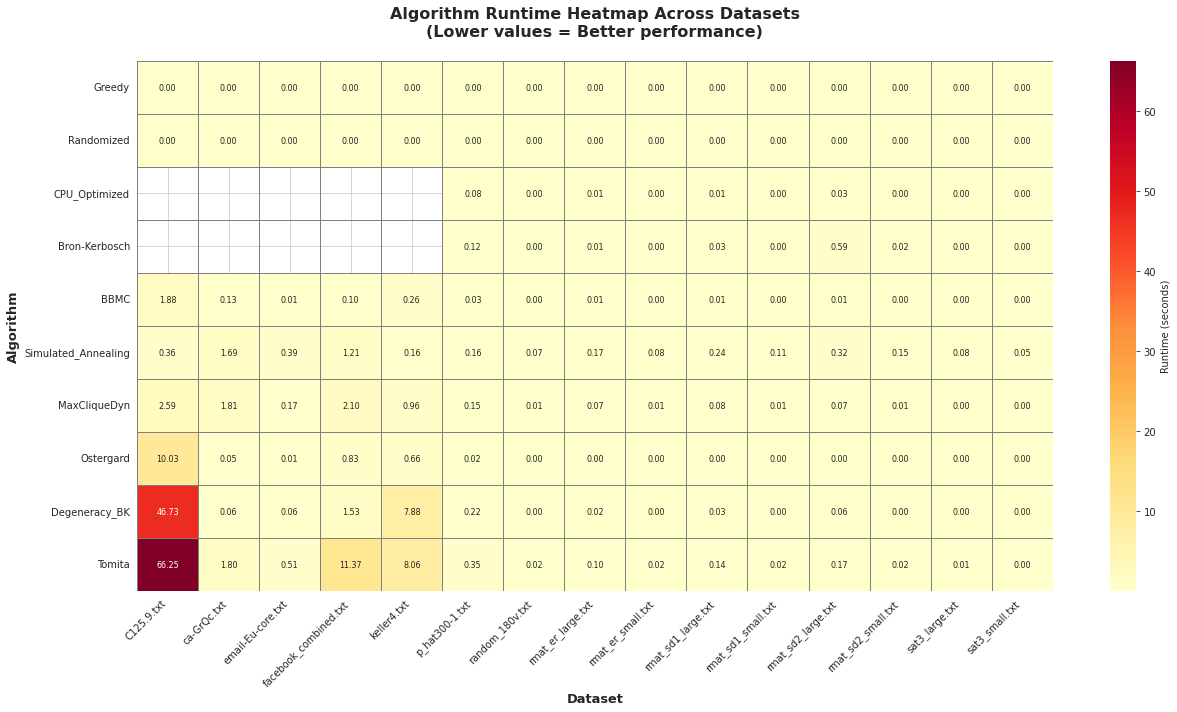

💾 Saved: benchmark_results/plot12_runtime_heatmap_20251120_081140.png



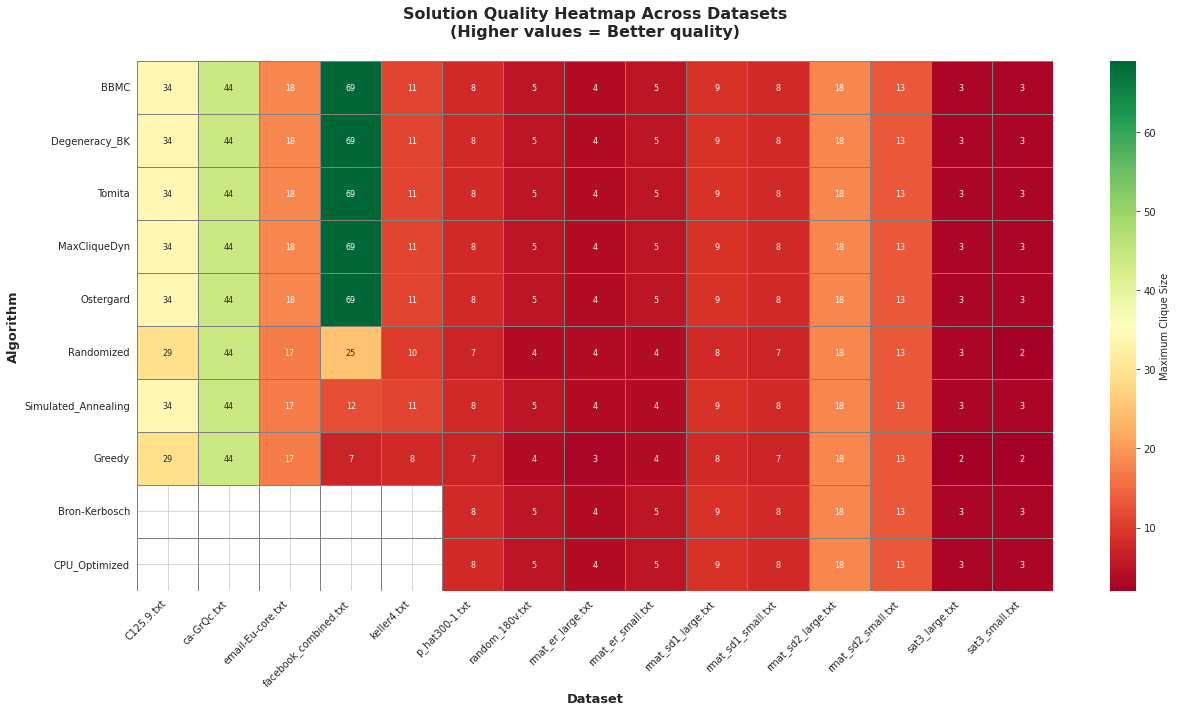

💾 Saved: benchmark_results/plot13_quality_heatmap_20251120_081140.png


📊 BEST ALGORITHM PER DATASET (by solution quality)

📁 C125.9.txt                     | Best: Simulated_Annealing  (clique= 34) | Fastest: Greedy               (0.0000s)
📁 ca-GrQc.txt                    | Best: Greedy               (clique= 44) | Fastest: Greedy               (0.0002s)
📁 email-Eu-core.txt              | Best: Tomita               (clique= 18) | Fastest: Greedy               (0.0000s)
📁 facebook_combined.txt          | Best: Tomita               (clique= 69) | Fastest: Greedy               (0.0002s)
📁 keller4.txt                    | Best: Simulated_Annealing  (clique= 11) | Fastest: Greedy               (0.0000s)
📁 p_hat300-1.txt                 | Best: Simulated_Annealing  (clique=  8) | Fastest: Greedy               (0.0000s)
📁 random_180v.txt                | Best: Simulated_Annealing  (clique=  5) | Fastest: Greedy               (0.0000s)
📁 rmat_er_large.txt              | Best: Randomized      

In [ ]:
if len(all_results) > 0 and len(df_success['Dataset'].unique()) > 1:
    # Plot 12: Runtime heatmap
    fig, ax = plt.subplots(figsize=(18, 10))
    
    pivot_time = df_success.pivot_table(
        index='Algorithm', 
        columns='Dataset', 
        values='Time(ms)',
        aggfunc='mean'
    )
    
    pivot_time['avg'] = pivot_time.mean(axis=1)
    pivot_time = pivot_time.sort_values('avg')
    pivot_time = pivot_time.drop('avg', axis=1)
    
    sns.heatmap(pivot_time, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, 
                cbar_kws={'label': 'Runtime (milliseconds)'},
                linewidths=0.8, linecolor='gray',
                annot_kws={'fontsize': 8})
    ax.set_title('Algorithm Runtime Heatmap Across Datasets\n(Lower values = Better performance)', 
                  fontsize=16, fontweight='bold', pad=25)
    ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
    ax.set_ylabel('Algorithm', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot12_runtime_heatmap_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Plot 13: Solution quality heatmap
    fig, ax = plt.subplots(figsize=(18, 10))
    
    pivot_clique = df_success.pivot_table(
        index='Algorithm', 
        columns='Dataset', 
        values='CliqueSize',
        aggfunc='mean'
    )
    
    pivot_clique['avg'] = pivot_clique.mean(axis=1)
    pivot_clique = pivot_clique.sort_values('avg', ascending=False)
    pivot_clique = pivot_clique.drop('avg', axis=1)
    
    sns.heatmap(pivot_clique, annot=True, fmt='.0f', cmap='RdYlGn', ax=ax, 
                cbar_kws={'label': 'Maximum Clique Size'},
                linewidths=0.8, linecolor='gray',
                annot_kws={'fontsize': 8})
    ax.set_title('Solution Quality Heatmap Across Datasets\n(Higher values = Better quality)', 
                  fontsize=16, fontweight='bold', pad=25)
    ax.set_xlabel('Dataset', fontsize=13, fontweight='bold')
    ax.set_ylabel('Algorithm', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    
    fig_path = os.path.join(RESULTS_FOLDER, f"plot13_quality_heatmap_{timestamp}.png")
    plt.savefig(fig_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"💾 Saved: {fig_path}\n")
    
    # Additional: Per-dataset performance ranking
    print(f"\n{'='*100}")
    print(f"📊 BEST ALGORITHM PER DATASET (by solution quality)")
    print(f"{'='*100}\n")
    
    for dataset in sorted(df_success['Dataset'].unique()):
        ds_data = df_success[df_success['Dataset'] == dataset]
        best = ds_data.loc[ds_data['CliqueSize'].idxmax()]
        fastest = ds_data.loc[ds_data['Time(ms)'].idxmin()]
        
        print(f"📁 {dataset:30s} | Best: {best['Algorithm']:20s} (clique={best['CliqueSize']:3d}) | "
              f"Fastest: {fastest['Algorithm']:20s} ({fastest['Time(ms)']:.2f}ms)")


## 13. Final Summary

In [27]:
if len(all_results) > 0:
    print(f"\n{'='*100}")
    print(f"✅ COMPREHENSIVE BENCHMARK COMPLETE")
    print(f"{'='*100}\n")
    
    print(f"📊 Statistics:")
    print(f"   Total datasets tested: {len(df_all['Dataset'].unique())}")
    print(f"   Total algorithm runs: {len(df_all)}")
    print(f"   Successful runs: {len(df_success)} ({len(df_success)/len(df_all)*100:.1f}%)")
    print(f"   Failed runs: {len(df_all) - len(df_success)}")
    
    print(f"\n🏆 Overall Best Performers:")
    
    # Fastest overall
    fastest_overall = df_success.groupby('Algorithm')['Time(s)'].mean().idxmin()
    fastest_time = df_success.groupby('Algorithm')['Time(s)'].mean().min()
    print(f"   ⚡ Fastest (avg): {fastest_overall} ({fastest_time:.4f}s)")
    
    # Best clique finder
    best_clique = df_success.groupby('Algorithm')['CliqueSize'].mean().idxmax()
    best_clique_size = df_success.groupby('Algorithm')['CliqueSize'].mean().max()
    print(f"   🎯 Best cliques (avg): {best_clique} ({best_clique_size:.2f})")
    
    print(f"\n📁 Results saved to: {RESULTS_FOLDER}/")
    print(f"   • Comprehensive CSV: benchmark_all_{timestamp}.csv")
    print(f"   • Algorithm summary: algorithm_summary_{timestamp}.csv")
    print(f"   • Visualizations: *.png")
    
    print(f"\n{'='*100}")
else:
    print("\n❌ No results generated")


✅ COMPREHENSIVE BENCHMARK COMPLETE

📊 Statistics:
   Total datasets tested: 15
   Total algorithm runs: 140
   Successful runs: 140 (100.0%)
   Failed runs: 0

🏆 Overall Best Performers:
   ⚡ Fastest (avg): Greedy (0.0000s)
   🎯 Best cliques (avg): BBMC (16.80)

📁 Results saved to: benchmark_results/
   • Comprehensive CSV: benchmark_all_20251120_081140.csv
   • Algorithm summary: algorithm_summary_20251120_081140.csv
   • Visualizations: *.png

